# 0. Load pickled result files

In [69]:
from glob import glob
from pickle import load
from scipy.stats import norm
import matplotlib.pyplot as plt
from simtk import unit
import numpy as np
%matplotlib inline

#pkls = glob('../data/estimator_comparison/*.pkl')
#pkls = glob('../data/water_cluster_flexible/*.pkl')
pkls = glob('../data/water_cluster_rigid/*.pkl')

In [70]:
len(pkls), len(pkls) / 136

(125, 0.9191176470588235)

In [71]:
summary = []

def extract_result(result):
    return result[1]['near_eq_estimate'], result[1]['new_estimate']

for fname in pkls:
    with open(fname, 'rb') as f:
        result = load(f)
    summary.append((result[0], extract_result(result)))

In [72]:
results = []
for fname in pkls:
    with open(fname, 'rb') as f:
        results.append(load(f))

In [147]:
dts = sorted(list(set([r[0][1].value_in_unit(unit.femtosecond) for r in results])))
dts

[0.10000000000000001,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0]

# 1. Examine work distributions

In [148]:
# assign a colormap to each scheme, so increasing dt progresses along that colormap

import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
colors = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()

for scheme in schemes:
    colormap = sns.color_palette(colors[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))

In [149]:
def remove_nans(array):
    return array[np.isfinite(array)]

In [150]:
remove_nans(results[-1][-1]['Ws'].flatten())

array([ 0.03651414, -0.01834182, -0.00577383, ...,  0.00405354,
       -0.03196801,  0.05771644])

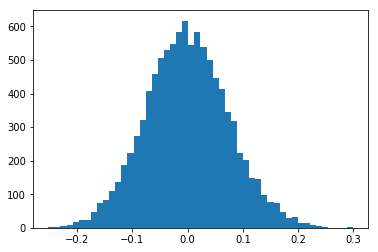

In [151]:
plt.hist(remove_nans(results[-1][-1]['Ws'].flatten()), bins=50);

In [160]:
def remove_nans(array):
    return array[np.isfinite(array)]

def get_work_distributions(scheme='RVOVR', marginal='configuration'):
    flat_Ws = []
    
    dts = []
    
    # get dt and a collection of work measurements for each 
    for summary, result in results:
        if summary[0] == scheme and summary[2] == marginal:
            flat_Ws.append(remove_nans(np.hstack(result['Ws'])))
            dts.append(summary[1].value_in_unit(unit.femtosecond))
    
    
    # sort everything by dt
    inds = np.argsort(dts)
    dts = np.array(dts)[inds]
    flat_Ws = [flat_Ws[i] for i in inds]
    
    return dts, flat_Ws
    

def plot_work_distributions(scheme='RVOVR', marginal='configuration', log=True, importance=False):
    
    dts, flat_Ws = get_work_distributions(scheme, marginal)
    
    n_to_skip = 2
    
    for (dt, Ws) in zip(dts[n_to_skip:], flat_Ws[n_to_skip:]):
        color = colormaps[scheme][dt]
        
        # get (density, bin_edges) then plot on midpoints
        y,x_ = np.histogram(Ws, density=True, bins='auto')
        x = (x_[1:] + x_[:-1]) / 2
        
        #plt.plot(x, y, '.', alpha=dt / 4, linewidth=1.0, color=color)
        plt.scatter(x, y, s=2.0, alpha=1.0, color=color)

        
        # also plot (log-)density of gaussian approximation?
        mu, sigma = np.mean(Ws), np.std(Ws)
        normal = norm(loc=mu, scale=sigma)
        
        n_sigma = 4
        x_grid = np.linspace(mu - n_sigma * sigma, mu + n_sigma * sigma, num=100)
        y_grid = normal.pdf(x_grid)
        plt.plot(x_grid, y_grid, linewidth=1.0, alpha=1.0, color=color, label=dt)
        plt.fill_between(x_grid, y_grid, alpha=0.1, color=color)
        
    if importance:
        # plot the e^{-w} importance weight?
        x_min = min([min(Ws) for Ws in flat_Ws])
        x_max = max([max(Ws) for Ws in flat_Ws])
        x_grid = np.linspace(x_min, x_max)
        y_grid = np.exp(-x_grid)
        plt.plot(x_grid, y_grid, '--', color='grey')
        
    plt.legend(title=r'$\Delta t$ (fs)', loc='best')
    
    plt.xlabel(r'work ($k_B T$)')
    
    ylabel = 'probability'
    if log:
        plt.yscale('log')
        ylabel = 'log-' + ylabel
    plt.ylabel(ylabel)
    plt.title('{}'.format(scheme))


def make_multi_panel_plot(marginal='configuration', log=True):
    plt.figure(figsize=(8,8))
    
    for i in range(len(schemes)):
        if i == 0:
            ax = plt.subplot(2,2,i+1)
        else:
            ax = plt.subplot(2,2,i+1, sharey=ax, sharex=ax)
        
        plot_work_distributions(schemes[i], marginal, log=log)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    plt.tight_layout()

    plt.savefig('work_distributions_water_cluster_{}.jpg'.format(marginal), dpi=300)

In [161]:
colors[schemes[0]]

'Blues'

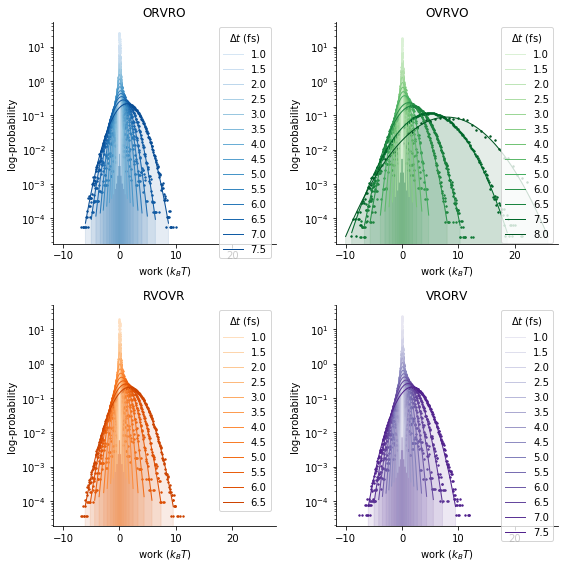

In [162]:
make_multi_panel_plot('configuration')

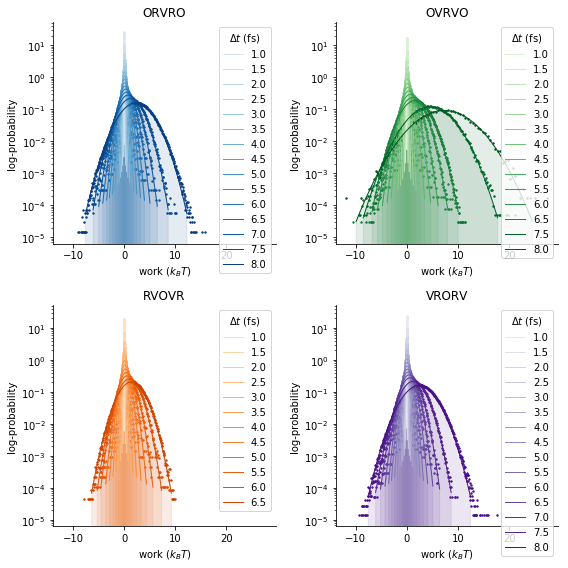

In [163]:
make_multi_panel_plot('full')

# 2. Plot standard deviation of work distribution as function of stepsize

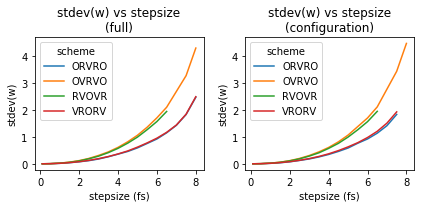

In [80]:
def plot_work_variances(marginal='full'):
    for scheme in schemes:
        dts, flat_Ws = get_work_distributions(scheme, marginal=marginal)
        plt.plot(dts, [np.std(Ws) for Ws in flat_Ws], label=scheme)

    plt.legend(title='scheme', loc='best')
    plt.title('stdev(w) vs stepsize\n({})'.format(marginal))
    plt.xlabel('stepsize (fs)')
    plt.ylabel('stdev(w)')
    
plt.figure(figsize=(6,3))
ax = plt.subplot(1,2,1)
plot_work_variances('full')
plt.subplot(1,2,2, sharey=ax)
plot_work_variances('configuration')

plt.tight_layout()
plt.savefig('w_stdev_wc.jpg', dpi=300)

# 3. Plot mismatch between $p(w)$ and $e^{-w} \cdot p(w)$

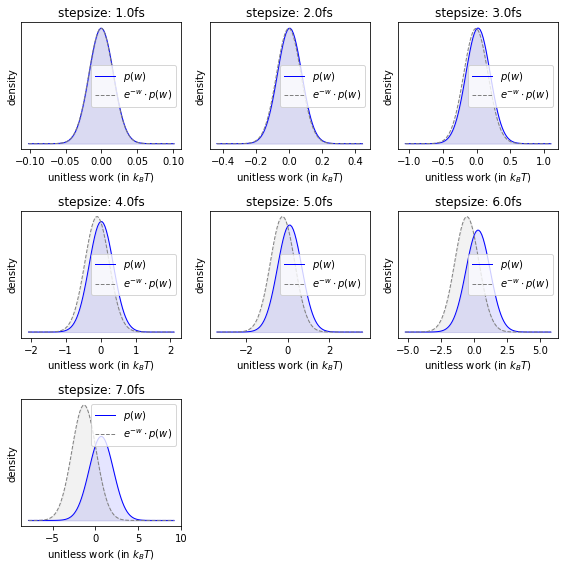

In [81]:
marginal = 'configuration'
scheme = schemes[0]
dts, flat_Ws = get_work_distributions(scheme, marginal=marginal)

n_skip=2

plt.figure(figsize=(8,8))
i = 1
for (dt, Ws) in zip(dts[n_skip:][::2], flat_Ws[n_skip:][::2]):
    plt.subplot(3,3,i)
    mu, sigma = np.mean(Ws), np.std(Ws)
    normal = norm(loc=mu, scale=sigma)

    n_sigma = 6
    x_grid = np.linspace(mu - n_sigma * sigma, mu + n_sigma * sigma, num=100)
    
    y_grid = normal.pdf(x_grid)
    plt.plot(x_grid, y_grid, linewidth=1.0, label=r'$p(w)$', color='blue', )
    plt.fill_between(x_grid, y_grid, linewidth=1.0, color='blue', alpha=0.1)
    
    y_grid = np.exp(normal.logpdf(x_grid) - x_grid)
    plt.plot(x_grid, y_grid, '--', linewidth=1.0, label=r'$e^{-w} \cdot p(w) $', color='grey')
    plt.fill_between(x_grid, y_grid, linewidth=1.0, color='grey', alpha=0.1)
    
    
    
    
    
    #plt.plot(dts, [np.std(Ws)**2 for Ws in flat_Ws], label=scheme)
#plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel(r'unitless work (in $k_B T$)')
    plt.yticks([])
    plt.ylabel('density')
    plt.title('stepsize: {}fs'.format(dt))
    
    i += 1
    
plt.tight_layout()
plt.savefig('p(w)-vs-exp(-w)p(w)_wc.jpg', bbox_inches='tight', dpi=300)

# 4. Plot near-equilibrium vs. "exact" estimates

In [82]:
def get_curves(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    new_estimates = []
    new_estimates_unc = []
    
    for (descr, (near_eq_est, new_est)) in summary:
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            near_eq_estimates.append(near_eq_est)
            new_estimates.append(new_est)
            
            
    
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, new_estimates]))



In [89]:
len(result[1])

4

In [99]:
result[1].keys()

dict_keys(['new_estimate', 'near_eq_estimate', 'W_shad_forward', 'Ws'])

In [93]:
result[1]['Ws'].shape

(200, 50)

In [96]:
len(results)

125

In [118]:
from benchmark.evaluation.compare_near_eq_and_exact import resample_Ws, process_outer_samples, estimate_from_work_samples
from tqdm import tqdm
n_bootstrap_samples = 100

means_new, stdevs_new = [], []


for result in tqdm(results):
    Ws = result[1]['Ws']
    samples_new = []
    #samples_near_eq = []
    
    for _ in range(n_bootstrap_samples):
        Ws_ = resample_Ws(Ws)
        new_estimate = np.mean([estimate_from_work_samples(w) for w in Ws_])
        
        samples_new.append(new_estimate)
        
    means_new.append(np.mean(samples_new))
    stdevs_new.append(np.std(samples_new))

means_new = np.array(means_new)
stdevs_new = np.array(stdevs_new)

100%|██████████| 125/125 [01:05<00:00,  2.49it/s]


In [119]:
# okay and a summary of the uncertainties in the near-eq estimates too


means_near_eq, stdevs_near_eq = [], []


for result in tqdm(results):
    W_F = result[1]["W_shad_forward"]
    Ws = result[1]['Ws']
    samples_near_eq = []
    
    for _ in range(n_bootstrap_samples):
        W_F_ = W_F[np.random.randint(0, len(W_F), len(W_F))]
        Ws_ = resample_Ws(Ws)
        
        near_eq_estimate = 0.5 * (np.mean(W_F_) - np.mean([np.mean(w) for w in Ws_]))
        samples_near_eq.append(near_eq_estimate)
        
    
    means_near_eq.append(np.mean(samples_near_eq))
    stdevs_near_eq.append(np.std(samples_near_eq))

means_near_eq = np.array(means_near_eq)
stdevs_near_eq = np.array(stdevs_near_eq)

100%|██████████| 125/125 [00:43<00:00,  3.60it/s]


In [121]:
def get_curves_with_unc(scheme='RVOVR', marginal='configuration'):
    dts = []
    
    near_eq_estimates = []
    near_eq_unc = []
    
    new_estimates = []
    new_estimates_unc = []
    
    for i, (descr, (near_eq_est, new_est)) in enumerate(summary):
        if descr[0] == scheme and descr[2] == marginal:
            dts.append(descr[1].value_in_unit(unit.femtosecond))
            
            near_eq_estimates.append(near_eq_est)
            new_estimates.append(new_est)
            
            near_eq_unc.append(stdevs_near_eq[i])
            new_estimates_unc.append(stdevs_new[i])
    
    inds = np.argsort(dts)
    sort_by_dt = lambda l : np.array(l)[inds]
    return list(map(sort_by_dt, [dts, near_eq_estimates, near_eq_unc, new_estimates, new_estimates_unc]))

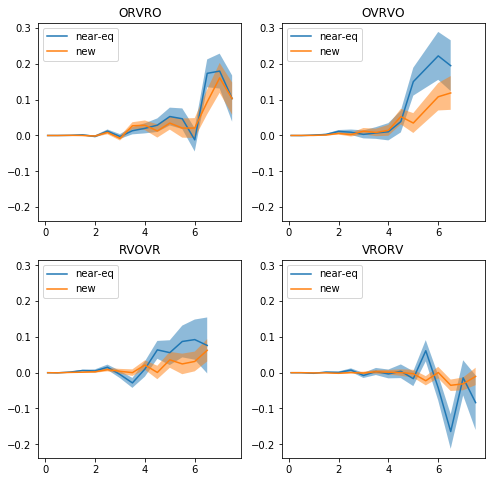

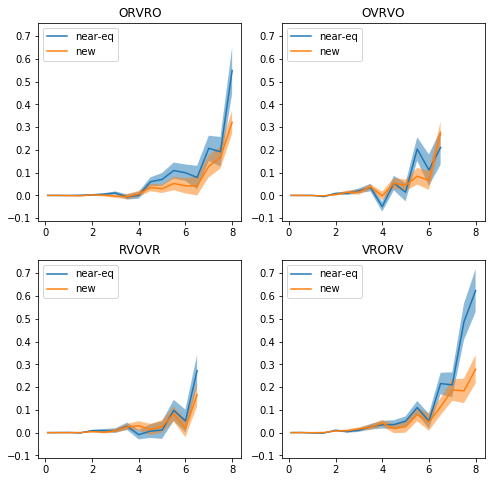

In [124]:
def new_figure():
    plt.figure(figsize=(8,8))

def plot_marginal(marginal='configuration'):
    
    for i, scheme in enumerate(sorted(['RVOVR', 'OVRVO', 'VRORV', 'ORVRO'])):
        dts, near_eq_estimates, near_eq_unc, new_estimates, new_estimates_unc = get_curves_with_unc(scheme, marginal)
        
        if i == 0:
            ax = plt.subplot(2,2,i+1)
        else:
            plt.subplot(2,2,i+1,sharey=ax, sharex=ax)
        plt.title(scheme)
        plt.plot(dts, near_eq_estimates, label='near-eq')
        plt.fill_between(dts, near_eq_estimates - near_eq_unc, near_eq_estimates + near_eq_unc, alpha=0.5)
        
        plt.plot(dts, new_estimates, label='new')
        plt.fill_between(dts, new_estimates - new_estimates_unc, new_estimates + new_estimates_unc, alpha=0.5)
        
        plt.legend(loc='upper left')

        
new_figure()
plot_marginal('configuration')
new_figure()
plot_marginal('full')

In [ ]:
# try to tighten the tolerance of the adaptive scheme

# 